Install the freshest stuff.

In [1]:
!pip install wandb pillow sympy graphviz opencv-python

/bin/bash: /home/mble/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/bin/bash: /home/mble/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun May 28 14:04:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
| 36%   49C    P8     1W / 175W |    158MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

2023-05-28 14:04:29.357334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 14:04:29.802736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-05-28 14:04:30.227181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:04:30.240212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:04:30.240384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Initialize data

In [3]:
import numpy as np
import cv2
from PIL import Image
from operator import itemgetter

def frame_to_array(frame):
    im_array = np.array(frame)
    im_array_shape = im_array.shape

    x = np.arange(im_array_shape[1])
    y = np.arange(im_array_shape[0])
    t = np.arange((1))
    t_shape = t.shape

    r = im_array[:,:,0]
    g = im_array[:,:,1]
    b = im_array[:,:,2]
    a = im_array[:,:,3] if im_array.shape[2] == 4 else None

    parameters = {"x": x, "y": y, "t": t, "r": r, "g": g, "b": b, "a": a}
    return parameters

def generate_input_output(parameters):
    x, y, t, r, g, b, a = itemgetter("x", "y", "t", "r", "g", "b", "a")(parameters)
    input_data = []
    output_data = []

    for i in range(len(y)):
        for j in range(len(x)):
            input_data.append([x[j], y[i], t[0]])
            output_data.append([r[i, j], g[i, j], b[i, j], a[i, j] if a is not None else 255])

    return np.array(input_data), np.array(output_data)

def video_frame_generator(video_path):
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        print("Error: Could not open the video file.")
        return None

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    current_frame = 0
    while True:
        ret, frame = video.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        parameters = frame_to_array(frame)
        parameters["t"] = np.array([current_frame]) / total_frames
        input, output = generate_input_output(parameters)

        # Normalize the input and output data
        im_array_shape = frame.shape
        input = input / np.array([im_array_shape[1], im_array_shape[0], 1])
        output = output / 255
                
        yield frame, input, output

        current_frame += 1

    video.release()

# video_path = "/home/mble/Videos/BoJack Horseman (2014) - S01E07 - Say Anything (1080p BluRay x265 )[Platz].mkv"
# frame_generator = video_frame_generator(video_path)
im_array = []
def image_to_parameters(path):
    # Load the image
    im = Image.open(path)

    # Convert the image to a numpy array
    global im_array
    im_array = np.array(im)

    # Extract the x, y values from the array
    x = np.arange(im_array.shape[1])
    y = np.arange(im_array.shape[0])
    t = [0]

    # Extract the color values from the array
    r = im_array[:,:,0]
    g = im_array[:,:,1]
    b = im_array[:,:,2]
    a = im_array[:,:,3] if im.mode == 'RGBA' else None
    
    parameters = {"x": x, "y": y, "t": t, "r": r, "g": g, "b": b, "a": a}
    return parameters

input, output = generate_input_output(image_to_parameters('./ImageAndVideoCompression/image2.png'))

# Normalize the input and output data
input = input / np.array([im_array.shape[1], im_array.shape[0], 1])
output = output / 255

Login to WandB

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: mble. Use `wandb login --relogin` to force relogin


True

Create model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential()
# model.add(Dense(128, input_shape=(3,), activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(32, activation='relu'))

model.add(Dense(512, input_shape=(3,), activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(4, activation='sigmoid'))

2023-05-28 14:04:32.143565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:04:32.143801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:04:32.143965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Compile model

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss='mean_squared_error',
    optimizer=opt
)

Compute RAM required

In [7]:
def estimate_memory_requirements(input, output, model):
    # Calculate the memory required for the input and output data
    input_data_memory = input.size * input.itemsize
    output_data_memory = output.size * output.itemsize

    # Calculate the memory required for the model weights
    model_weights_memory = 0
    for layer in model.layers:
        layer_weights = layer.get_weights()
        for weight in layer_weights:
            model_weights_memory += weight.size * weight.itemsize

    # Calculate the total memory requirement
    total_memory = input_data_memory + output_data_memory + model_weights_memory

    return total_memory

# Estimate the memory requirements for the given input, output, and model
# total_memory = estimate_memory_requirements(input, output, model)
# print(f"Estimated memory requirement: {total_memory} bytes")

Define showing an image

In [8]:
import numpy as np
from PIL import Image
from IPython.display import display
from tensorflow.keras.callbacks import Callback

class DisplayImage(Callback):
    # def __init__(self, frame):
    #     super().__init__()
    #     self.frame = frame

    def on_epoch_end(self, epoch, logs=None):
        # Use the model to predict the output for the given input data
        predicted_output = model.predict(input)

        # Reshape the predicted output to match the original image dimensions
        # predicted_output = predicted_output.reshape(self.frame.shape[0], self.frame.shape[1], -1)
        predicted_output = predicted_output.reshape(im_array.shape[0], im_array.shape[1], -1)

        # Convert the predicted output back to the original scale (0-255)
        predicted_output = (predicted_output * 255).astype(np.uint8)

        # Create a new image using the predicted output
        predicted_image = Image.fromarray(predicted_output, mode='RGBA')

        # Display the new image
        display(predicted_image)
        
display_image = DisplayImage()

WandB

In [9]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

# Initialize wandb
run = wandb.init(project='Image compression', entity='mble', config={
    'batch_size': 512,
    'epochs': 128
})

Save model

In [10]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "training/2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        verbose=1)

Train a model

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/128


2023-05-28 14:04:36.183824: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1eb897b1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 14:04:36.183846: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-05-28 14:04:36.186233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-28 14:04:36.262311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-28 14:04:36.330088: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6755/6755 [==============================] - 4s 522us/step


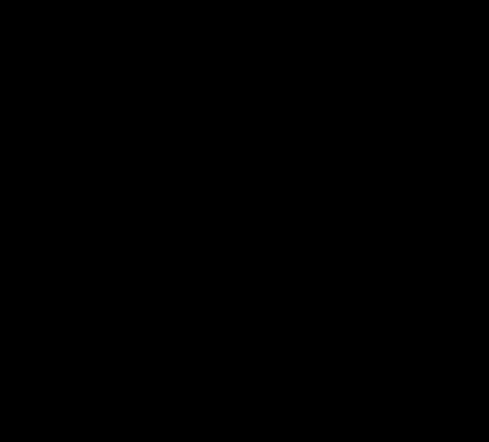


Epoch 1: saving model to training/2/cp.ckpt
423/423 [==============================] - 10s 20ms/step - loss: 0.0410
Epoch 2/128
6755/6755 [==============================] - 3s 516us/step


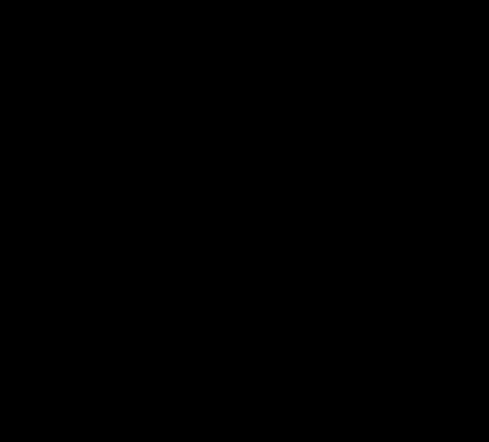


Epoch 2: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 3/128
6755/6755 [==============================] - 3s 504us/step


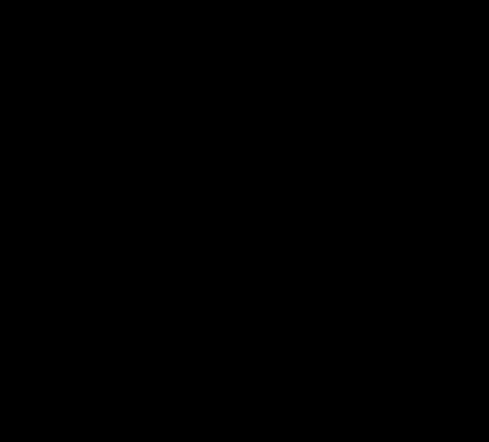


Epoch 3: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 16ms/step - loss: 0.0403
Epoch 4/128
6755/6755 [==============================] - 3s 498us/step


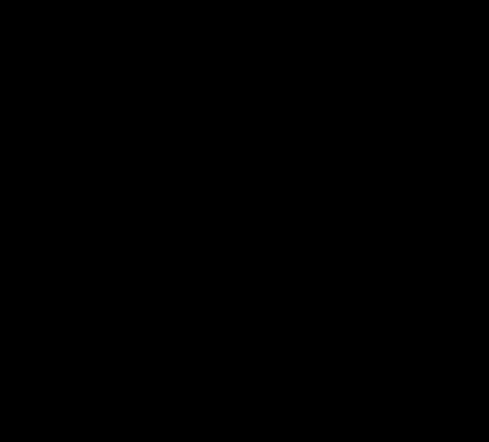


Epoch 4: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 16ms/step - loss: 0.0403
Epoch 5/128
6755/6755 [==============================] - 4s 518us/step


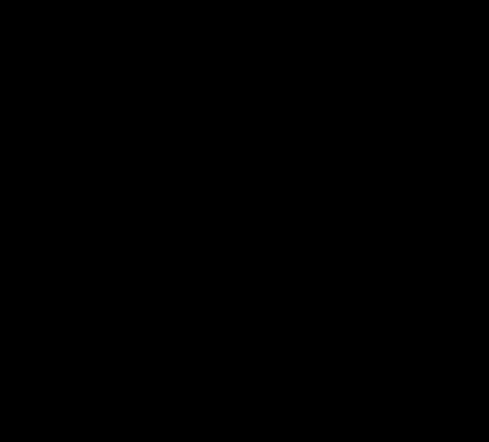


Epoch 5: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 6/128
6755/6755 [==============================] - 4s 577us/step


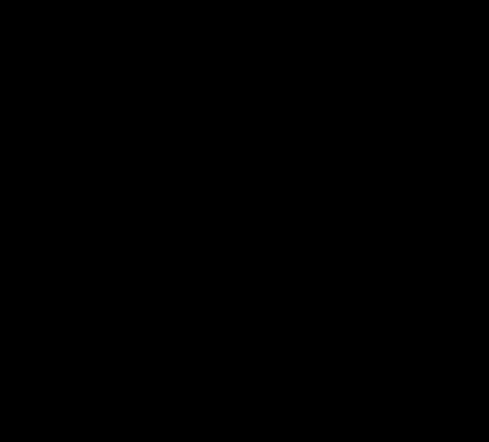


Epoch 6: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 18ms/step - loss: 0.0403
Epoch 7/128
6755/6755 [==============================] - 4s 527us/step


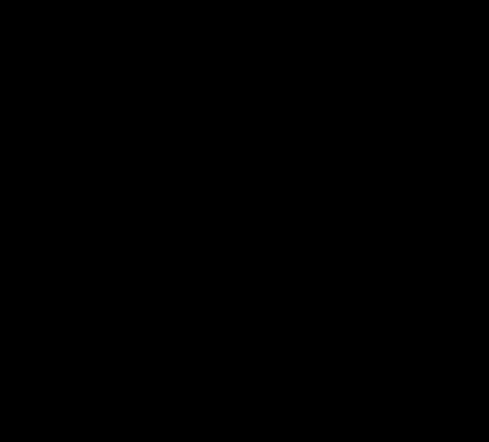


Epoch 7: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 8/128
6755/6755 [==============================] - 4s 536us/step


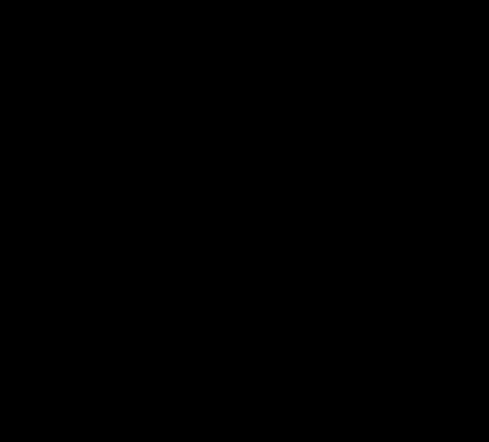


Epoch 8: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 9/128
6755/6755 [==============================] - 4s 599us/step


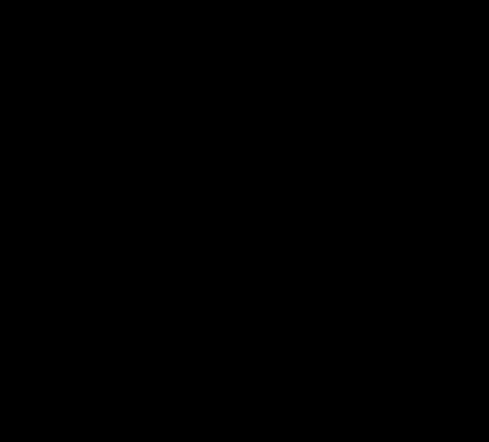


Epoch 9: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 19ms/step - loss: 0.0403
Epoch 10/128
6755/6755 [==============================] - 4s 535us/step


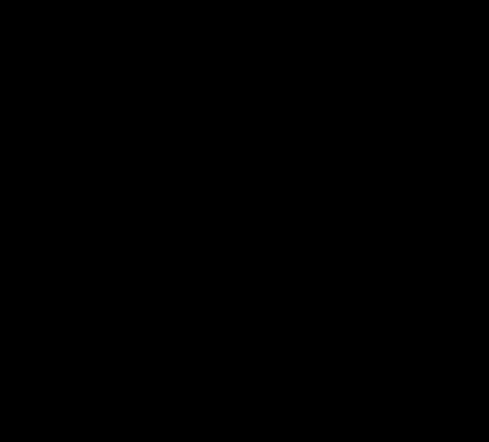


Epoch 10: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 18ms/step - loss: 0.0403
Epoch 11/128
6755/6755 [==============================] - 6s 863us/step


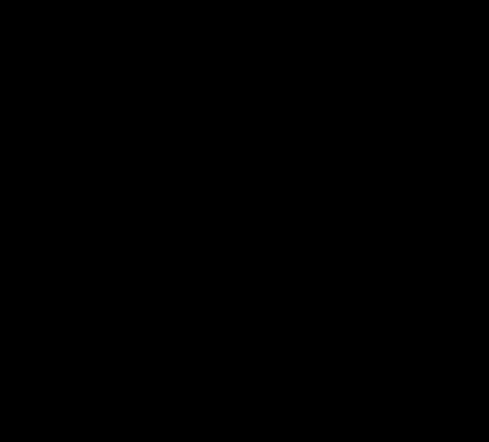


Epoch 11: saving model to training/2/cp.ckpt
423/423 [==============================] - 10s 23ms/step - loss: 0.0403
Epoch 12/128
6755/6755 [==============================] - 3s 514us/step


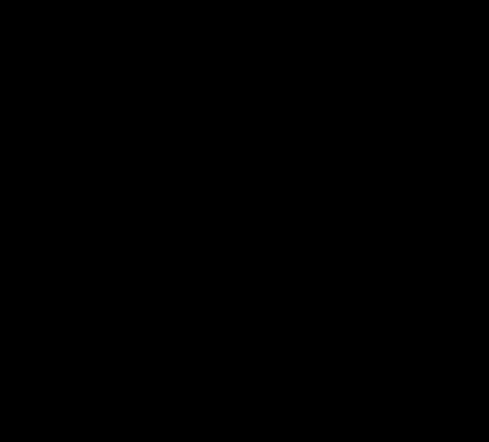


Epoch 12: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 13/128
6755/6755 [==============================] - 4s 529us/step


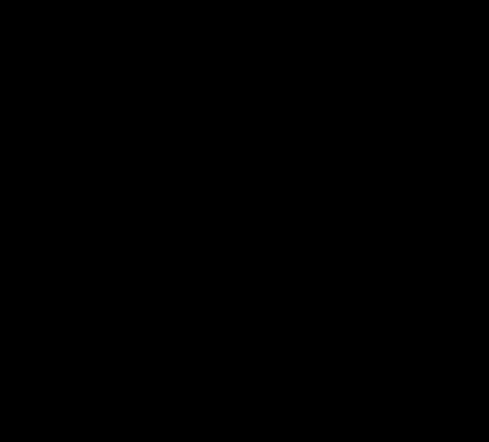


Epoch 13: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 14/128
6755/6755 [==============================] - 3s 495us/step


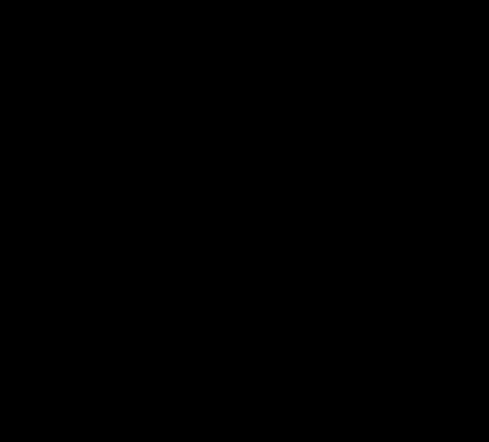


Epoch 14: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 15/128
6755/6755 [==============================] - 3s 509us/step


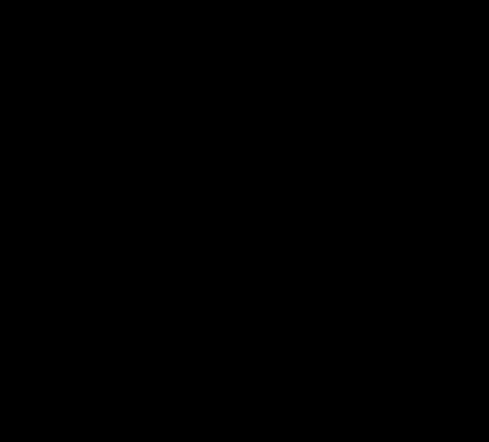


Epoch 15: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 16/128
6755/6755 [==============================] - 3s 514us/step


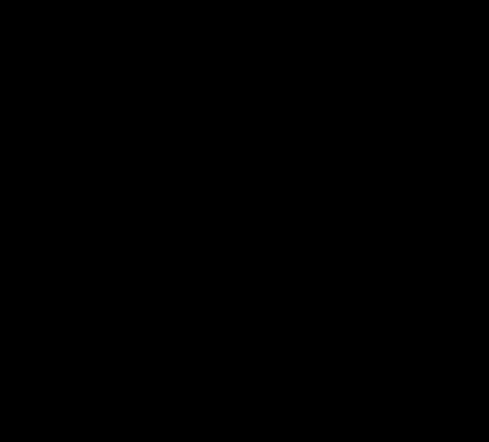


Epoch 16: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 17/128
6755/6755 [==============================] - 4s 578us/step


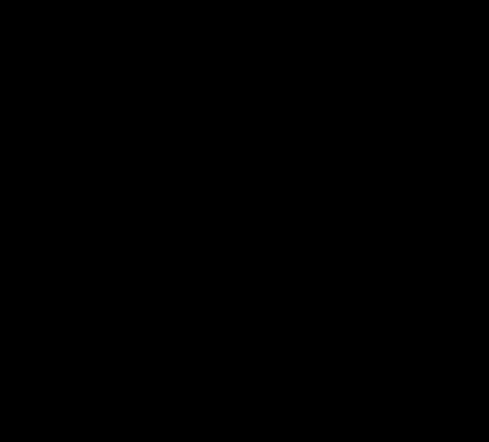


Epoch 17: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 18ms/step - loss: 0.0403
Epoch 18/128
6755/6755 [==============================] - 4s 629us/step


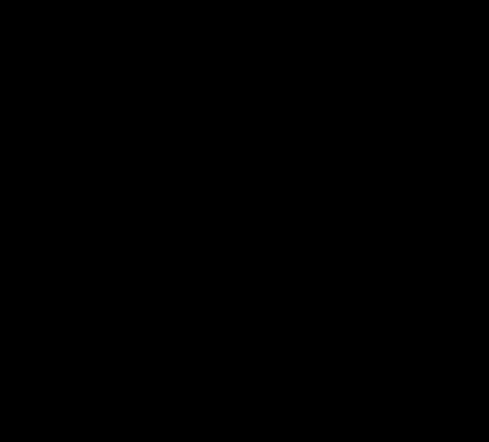


Epoch 18: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 19ms/step - loss: 0.0403
Epoch 19/128
6755/6755 [==============================] - 4s 609us/step


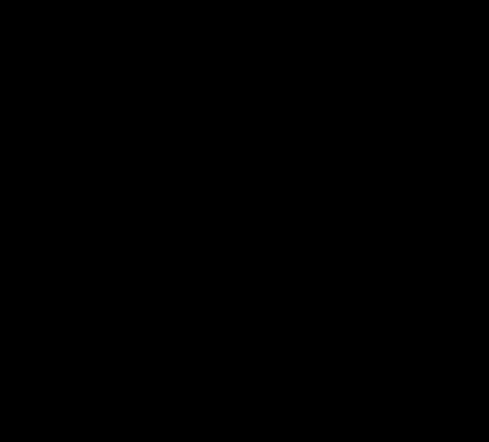


Epoch 19: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 19ms/step - loss: 0.0403
Epoch 20/128
6755/6755 [==============================] - 4s 528us/step


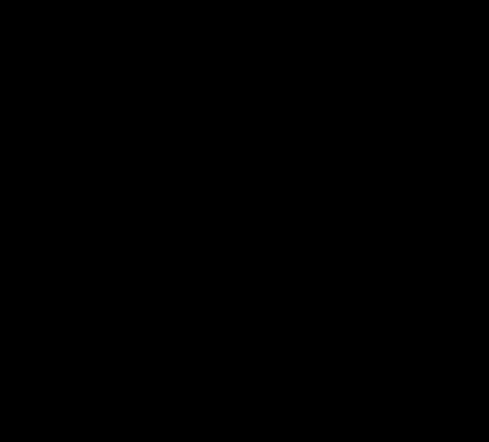


Epoch 20: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 21/128
6755/6755 [==============================] - 6s 849us/step


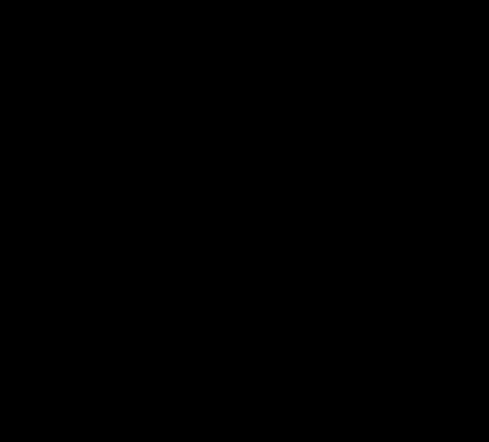


Epoch 21: saving model to training/2/cp.ckpt
423/423 [==============================] - 10s 23ms/step - loss: 0.0403
Epoch 22/128
6755/6755 [==============================] - 4s 531us/step


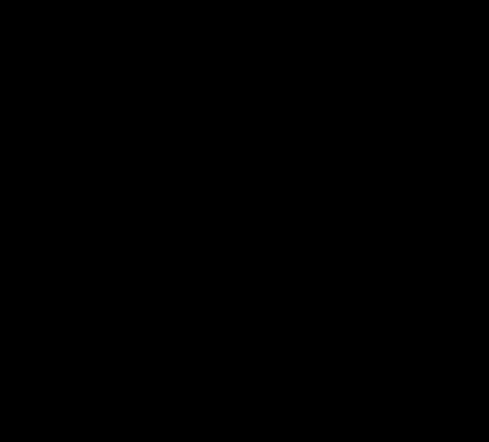


Epoch 22: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 18ms/step - loss: 0.0403
Epoch 23/128
6755/6755 [==============================] - 4s 522us/step


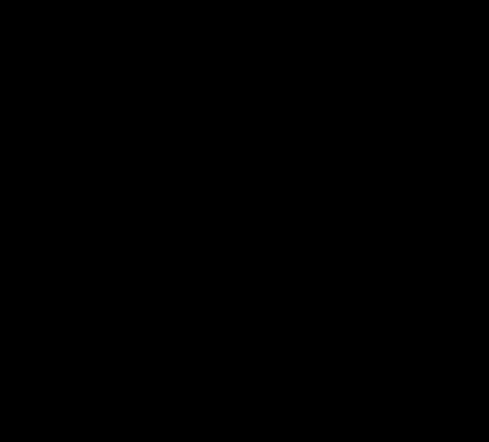


Epoch 23: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 24/128
6755/6755 [==============================] - 4s 517us/step


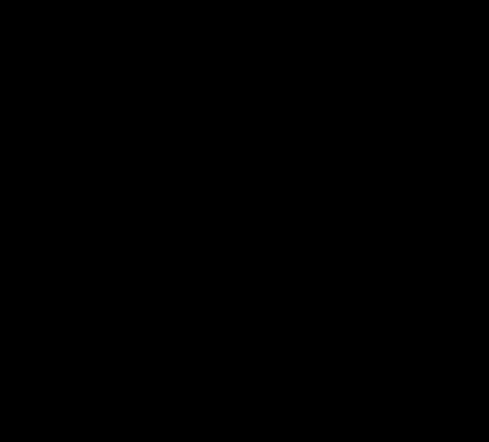


Epoch 24: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 25/128
6755/6755 [==============================] - 3s 511us/step


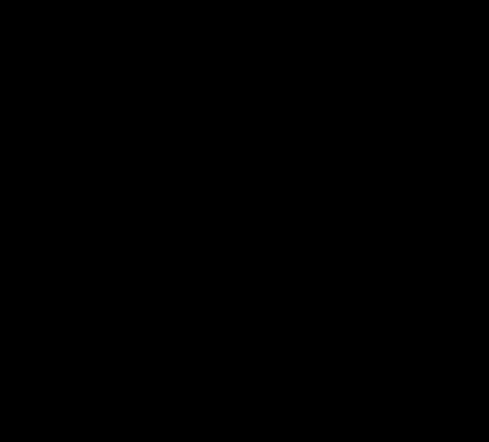


Epoch 25: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 26/128
6755/6755 [==============================] - 4s 621us/step


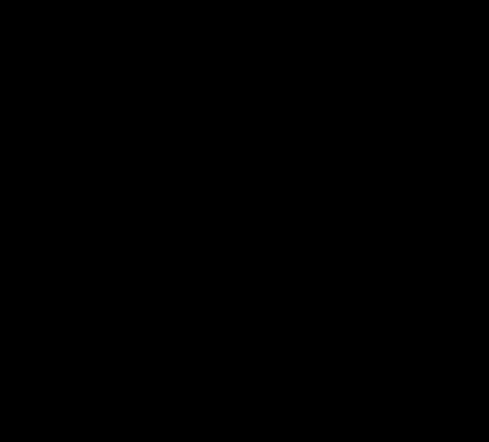


Epoch 26: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 18ms/step - loss: 0.0403
Epoch 27/128
6755/6755 [==============================] - 4s 623us/step


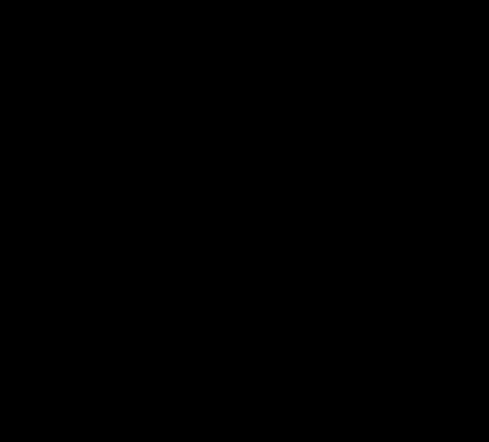


Epoch 27: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 19ms/step - loss: 0.0403
Epoch 28/128
6755/6755 [==============================] - 3s 511us/step


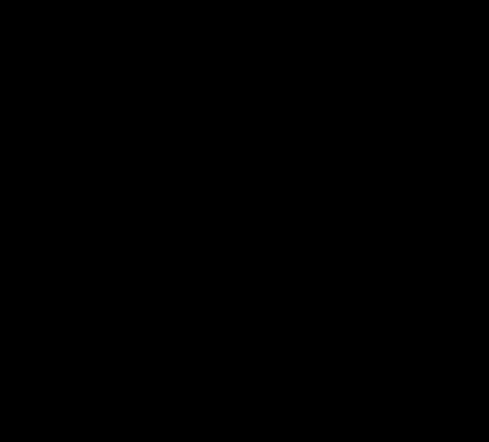


Epoch 28: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 29/128
6755/6755 [==============================] - 3s 500us/step


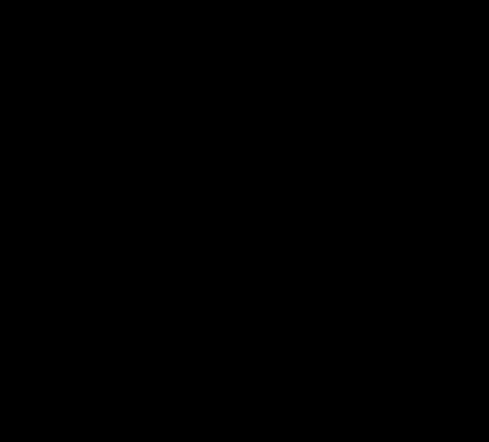


Epoch 29: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 16ms/step - loss: 0.0403
Epoch 30/128
6755/6755 [==============================] - 3s 511us/step


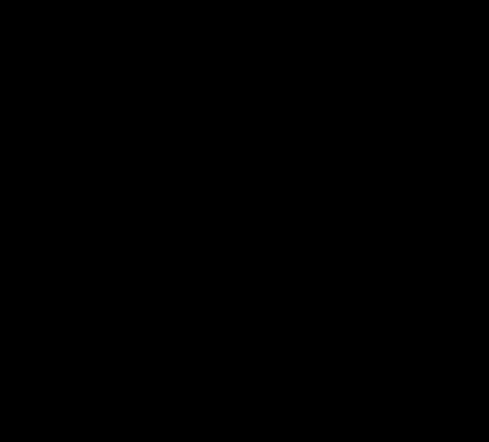


Epoch 30: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 31/128
6755/6755 [==============================] - 3s 516us/step


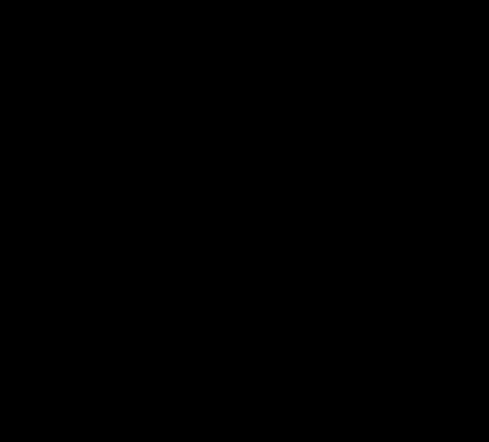


Epoch 31: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 32/128
6755/6755 [==============================] - 3s 499us/step


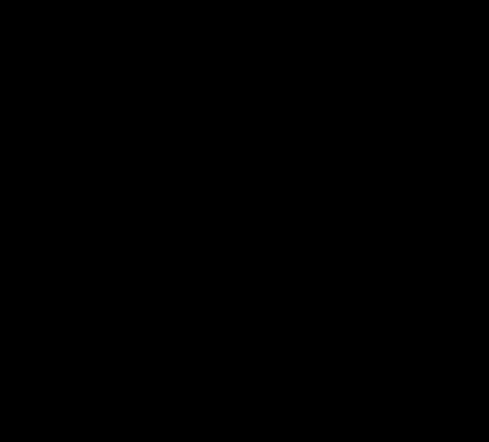


Epoch 32: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 33/128
6755/6755 [==============================] - 3s 496us/step


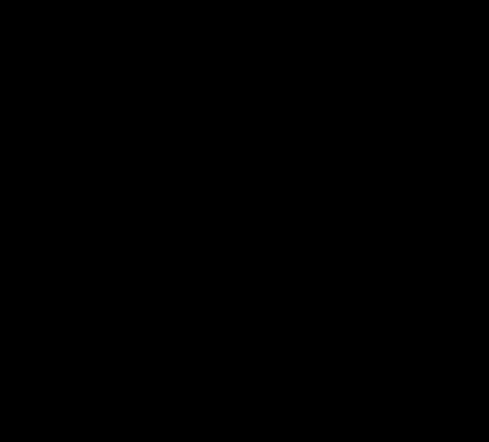


Epoch 33: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 34/128
6755/6755 [==============================] - 3s 500us/step


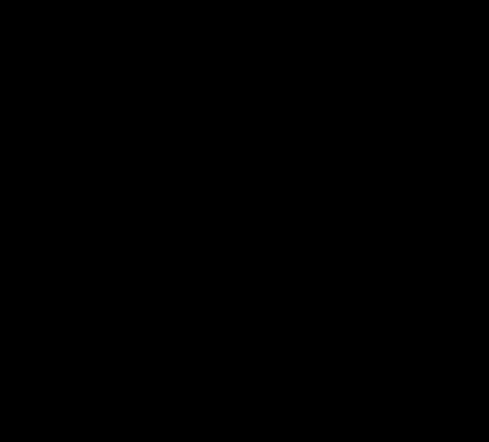


Epoch 34: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 16ms/step - loss: 0.0403
Epoch 35/128
6755/6755 [==============================] - 3s 515us/step


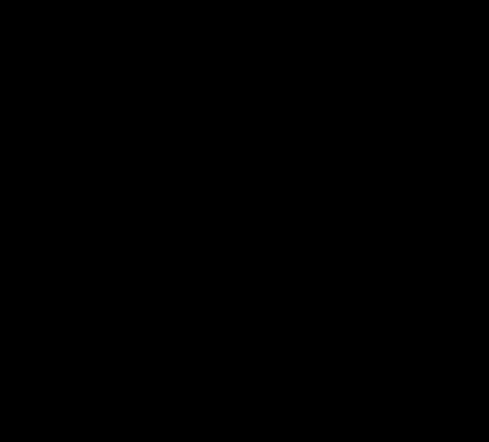


Epoch 35: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 36/128
6755/6755 [==============================] - 3s 510us/step


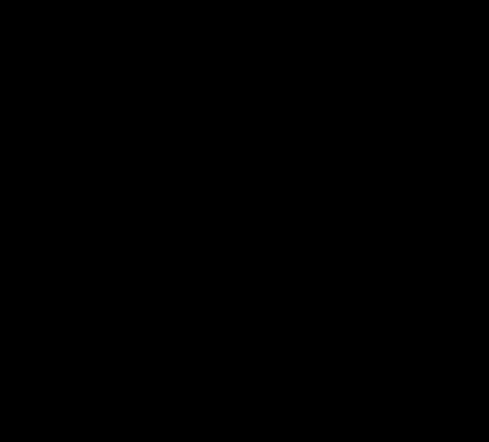


Epoch 36: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 37/128
6755/6755 [==============================] - 4s 576us/step


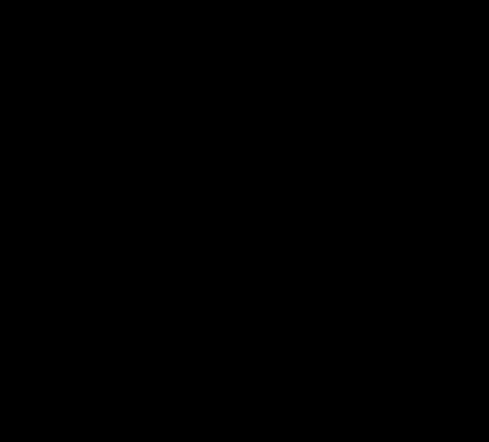


Epoch 37: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 18ms/step - loss: 0.0403
Epoch 38/128
6755/6755 [==============================] - 4s 587us/step


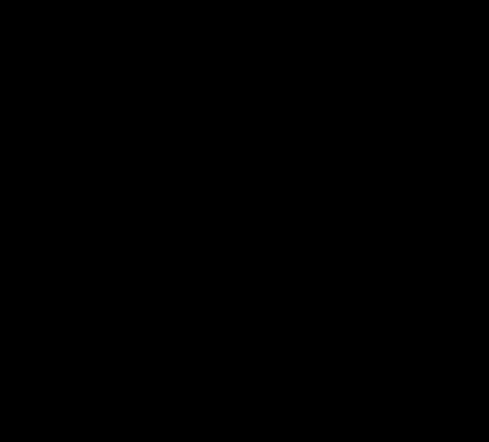


Epoch 38: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 18ms/step - loss: 0.0403
Epoch 39/128
6755/6755 [==============================] - 4s 595us/step


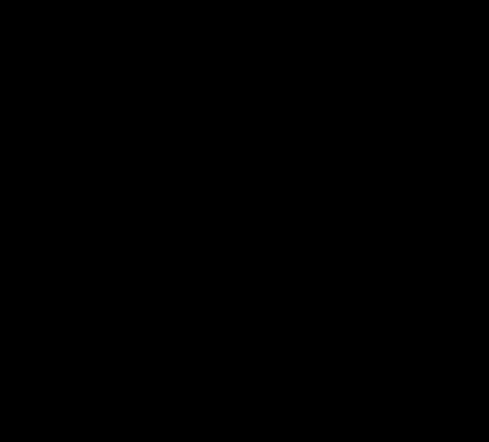


Epoch 39: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 19ms/step - loss: 0.0403
Epoch 40/128
6755/6755 [==============================] - 4s 590us/step


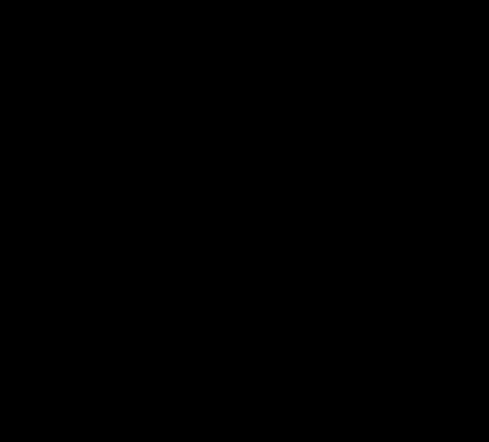


Epoch 40: saving model to training/2/cp.ckpt
423/423 [==============================] - 8s 18ms/step - loss: 0.0403
Epoch 41/128
6755/6755 [==============================] - 4s 517us/step


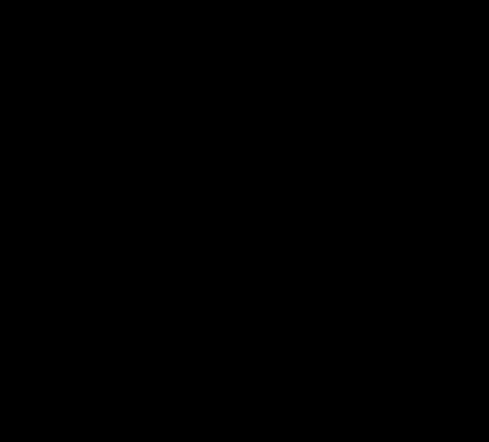


Epoch 41: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 42/128
6755/6755 [==============================] - 4s 516us/step


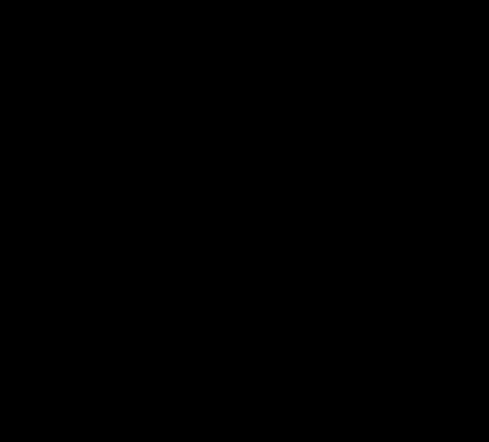


Epoch 42: saving model to training/2/cp.ckpt
423/423 [==============================] - 7s 17ms/step - loss: 0.0403
Epoch 43/128
 20/423 [>.............................] - ETA: 2s - loss: 0.0399

KeyboardInterrupt: 

In [11]:
# empty_frame = np.zeros((1, 1, 3), dtype=np.uint8)
# display_image = DisplayImage(empty_frame)

# for frame, input, output in frame_generator:
#     display_image.frame = frame
#     # Train the model
#     model.fit(input, output, epochs=4, batch_size=32768, validation_split=0, use_multiprocessing = True, callbacks=[WandbCallback()])
#     checkpoint
#     display_image.on_epoch_end()

model.fit(input, output, epochs=128, batch_size=512, validation_split=0, use_multiprocessing = True, callbacks=[display_image, WandbCallback(), checkpoint])

# End WandB
run.finish()